# I. Import Libraries and data

In [2]:
%pip install gdown
%pip install cartopy
%pip install seaborn
%pip install libpysal
%pip install esda
%pip install --upgrade gdown
%pip install --upgrade jupyter ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/70/1a/7edeedb1c089d63ccd8bd5c0612334774e90cf9337de9fe6c82d90081791/ipywidgets-8.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.10 from https://files.pythonhosted.org/packages/99/bc/82a8c3985209ca7c0a61b383c80e015fd92e74f8ba0ec1af98f9d6ca8dce/widgetsnbextension-4.0.10-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.10 from https://files.pythonhosted.org/packages/24/da/db1cb0387a7e4086780aff137987ee924e953d7f91b2a870f994

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [1]:
# A few imports to make everything work
import gdown
import zipfile
import os
import pandas as pd
import numpy as np
import random
import geopandas as gpd
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from itertools import cycle
from ipywidgets import widgets, interactive
from datetime import datetime
import warnings
import seaborn as sns
import sys
import seaborn as sns
from shapely.geometry import Point
import matplotlib.animation as animation
from IPython.display import HTML
from libpysal.weights import Queen
from esda.moran import Moran
from scipy.stats import invgamma
import copy
from sklearn.preprocessing import StandardScaler

# Getting rid of a few warnings (can be toggled off)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Install cmdstanpy module
# !pip install cmdstanpy

# Install arviz module (With version 2.33.1 you will need a special version of arviz)
# !pip install git+https://github.com/OriolAbril/arviz.git@ci

# Install cmdstan -- Just for the first time!
# from cmdstanpy import install_cmdstan
# install_cmdstan()

# Import modules for stan
# import arviz as az

# Import functions for stan
# from cmdstanpy import CmdStanModel

In [ ]:
file_id = '1EQjwC00wD1-tjtwS8XgS__dGYvpovg51'
gdown_link = f'https://drive.google.com/uc?id={file_id}'

zip_path = 'content/dati_ozono.zip'
gdown.download(gdown_link, zip_path, quiet=False)

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [2]:
csv_files = [file for file in os.listdir('/content/dati_ozono') if file.endswith('.csv')]
dataframes = {file: pd.read_csv(os.path.join('/content/dati_ozono', file)) for file in csv_files}

print(csv_files)

['datasetO3.csv', 'stazioni_O3.csv']


In [3]:
for filename, df in dataframes.items():
    print(f"Contents of {filename}:")
    print(df.head())

Contents of datasetO3.csv:
   idSensore                    Data  Valore Stato  idOperatore
0       5707  01/01/2010 01:00:00 AM     2.9    VA            1
1       5707  01/01/2010 02:00:00 AM     2.9    VA            1
2       5707  01/01/2010 03:00:00 AM     2.9    VA            1
3       5707  01/01/2010 04:00:00 AM     2.9    VA            1
4       5707  01/01/2010 05:00:00 AM     2.9    VA            1
Contents of stazioni_O3.csv:
   Unnamed: 0  IdSensore NomeTipoSensore UnitaMisura  Idstazione  \
0           7       5749           Ozono       µg/m³         554   
1          11       5735           Ozono       µg/m³         576   
2          21      10324           Ozono       µg/m³         707   
3          25      10112           Ozono       µg/m³         698   
4          41       5738           Ozono       µg/m³         607   

                  NomeStazione  Quota Provincia           Comune Storico  \
0          Saronno v.Santuario  212.0        VA          Saronno       N   

In [4]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# II. Initial Merges of the data

In [5]:
# Reading of the first DB
df1 = dataframes['datasetO3.csv']
df1 = df1.loc[:,['idSensore','Valore','Data']]

sensors = df1['idSensore'].unique().tolist()
print(f'Whole dataset contains {df1.shape[0]} data from {len(sensors)} sensors')

Whole dataset contains 5552198 data from 51 sensors


In [6]:
# Create the actual dataframe for datasetO3
df_data = pd.DataFrame(columns=['idSensore','Valore','Data'])

# Turn hourly data into week averages
for sensor in sensors:
  df_temp = df1[df1['idSensore'] == sensor].copy()
  df_temp['Data'] = pd.to_datetime(df_temp['Data'], format='%m/%d/%Y %I:%M:%S %p')
  # Insert in the actual dataset the shrinked one
  df_data = pd.concat([df_data, df_temp.resample('W', on='Data').mean(numeric_only=True)])

# Fixing indexes
df_data.Data = df_data.index
df_data.index = range(df_data.shape[0])

In [7]:
#Reading of the second DB
df_stat = dataframes['stazioni_O3.csv']

# Join both DBs into the final one: 'df'
df = df_data.join(df_stat.set_index('IdSensore'), on='idSensore')
df = df.dropna(subset=['idSensore'])
df['Data'] = pd.to_datetime(df['Data'])

# [Corrected from before] now df has only the data collected in 2010-2017 timespan, independently on when the station started/ended to collect them
startm = '2010-01-01'
endm = '2017-12-31'
df = df.loc[(df['Data'] >= startm) & (df['Data'] <= endm)]
df = df.reset_index()

# III. Useful functions

In [ ]:
# Some useful lists to simplify stuff
cities = df.Comune.unique().tolist()
sensors = list(map(int, df.idSensore.unique().tolist()))
years = list(range(2010,2018,1))
provinces = df.Provincia.unique().tolist()

In [ ]:
def gen_filtered_df(df=df, cities=None, ids=None, timespan=None, provs=None):
  """
   This function generates a new dataframe based on filters given as (optional) parameters
   Args:
   cities (list/None): [Comune1, Comune2, ...]
   ids (list/None): [idSensore1, idSensore2, ...]
   timespan (list/None): [2010, ...]
   provs (list/None): [Provincia1, ....]
   Returns: an instance of the filtered dataframe
  """
  df_filtered = df.copy()
  if cities is not None:
    df_filtered = df_filtered[df_filtered['Comune'].isin(cities)]
  if ids is not None:
    df_filtered = df_filtered[df_filtered['idSensore'].isin(ids)]
  if timespan is not None:
    df_filtered = df_filtered[df_filtered['Data'].dt.year.isin(timespan)]
  if provs is not None:
    df_filtered = df_filtered[df_filtered['Provincia'].isin(provs)]
  return df_filtered

In [ ]:
def randgenCY_df(df=df, cities=cities, years=years):
    """
    This function generates a dataframe out of a few random cities and a random timespan
    Args: (do not change pls)
    cities, years (list): lists of all unique cities and years
    Returns: randomly generated dataframe
    """
    # the '6' can be changed to extract more cities in the dataframe (if you do it, please change the code to extract a feasible amount of years)
    ext_num = random.sample(range(1, 6), 2)
    ext_cities = random.sample(cities, ext_num[0])
    ext_year_start = random.randint(0, len(years) - ext_num[1] - 1)
    ext_years = list(years[ext_year_start: ext_year_start + ext_num[1]])
    print(f'Generating a dataframe based on data from {ext_cities} during years {ext_years}')

    return gen_filtered_df(df, cities=ext_cities, timespan=ext_years)

In [ ]:
def randgenSY_df(df=df, sensors=sensors, years=years):
    """
    This function generates a dataframe out of a few random sensors and a random timespan
    Args: (do not change pls)
    sensors, years (list): lists of all unique sensors(ids) and years
    Returns: randomly generated dataframe
    """
    # the '6' can be changed to extract more sensors in the dataframe (if you do it, please change the code to extract a feasible amount of years)
    ext_num = random.sample(range(1, 6), 2)
    ext_sensors = random.sample(sensors, ext_num[0])
    ext_year_start = random.randint(0, len(years) - ext_num[1] - 1)
    ext_years = list(years[ext_year_start: ext_year_start + ext_num[1]])

    print(f'Generating a dataframe based on data from sensors: {ext_sensors} during years {ext_years}')

    return gen_filtered_df(df, ids=ext_sensors, timespan=ext_years)

In [ ]:
def plot_stations(df=df, provinces=provinces):
  """
  This function plots the approximate location of stations measuring ozone across Lombardy
  Args: (do not change df)
  provinces (list): lists of all unique provinces [default], list of filtered provinces to plot
  Returns: map of northern part of Italy
  """
  # Obtain Italy border (couldn't find the regional-specific one, sorry)
  italy = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
  italy = italy[italy['name'] == 'Italy']

  # Use this projection to base the plot on coordinates
  fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))

  # Draw actual borders
  italy.boundary.plot(ax=ax, color='black', linewidth=1.5)

  colors = cycle(plt.cm.tab10.colors)
  # For each province, choose a color and plot locations of stations in that province
  for p in provinces:
    df_provs = df[df['Provincia'] == p]
    cur_col = next(colors)
    ax.scatter(df_provs['lng'], df_provs['lat'], label=p, color=cur_col, s=7.5)

  # Adjust plot
  ax.set_ylim(44,47)
  ax.set_xlim(8,12)
  ax.set_title('Ozone stations in Lombardy')
  ax.legend()

  # Visualizza la mappa
  plt.show()

In [ ]:
def plot_values(df_list):
  """
  This function plots, for each dataframe in the list, the distribution of values over time
  [IMPORTANT]: Don't submit lists too long or dataframes too big, it doesn't work
  Args:
  df_list (list): list of dataframes with max length of 15
  Returns: subplots of each dataframe's values over time
  """
  # Just checking if you do something like "plot me the whole dataset"
  if len(df_list) > 15:
    print('This function should receive a smaller list of dataframes. Please reduce the size of df_list parameter')
    return

  # Plotting one for each row to keep it understandable
  fig, axs = plt.subplots(len(df_list), 1, figsize=(15, 35))

  for i, df_temp in enumerate(df_list):
    # Filter relevant columns, remove data if sensor is unknown (i think there's enough data to simply drop those lines and not try to infer NaN values)
    df_plot = df_temp[['Comune', 'Data', 'Valore', 'idSensore']]
    df_plot = df_plot.dropna(subset=['idSensore'], axis=0)

    df_plot = df_plot.sort_values(by='Data')
    colors = cycle(plt.cm.tab10.colors)

    for sensor, group in df_plot.groupby('idSensore'):
        cur_col = next(colors)
        # Finding nan values and plot markers in corrispondence of the missing point
        nan_indices = group['Valore'].isna()
        axs[i].plot(group['Data'][nan_indices], [0] * nan_indices.sum(), 'o', markersize=5, color=cur_col)

        axs[i].plot(group['Data'], group['Valore'], label=f'{group["Comune"].iloc[0]}', color=cur_col)

    axs[i].axhline(y=80, color='black', linestyle='--', alpha=0.1, label='Security Threshold')

    axs[i].legend()

  plt.xlabel('Date')
  plt.ylabel('Value')

  plt.show()

In [ ]:
def plot_rollingavg(df):
    """
    This function plots the moving average for each sensor in the dataframe given as parameter
    Args:
    - df: dataframe containing measurements (better if it is a provincial dataset rather than the full one)
    """

    df['Data'] = pd.to_datetime(df['Data'])
    df.sort_values(by=['idSensore', 'Data'], inplace=True)
    # Just some garbage variables since idk how to make the title looking nice
    provs_dict = {'MI': 'Milano','MB': 'Monza e Brianza','CO': 'Como','LC': 'Lecco','LO': 'Lodi','SO': 'Sondrio','VA': 'Varese','CR': 'Cremona','PV': 'Pavia','BS': 'Brescia','MN': 'Mantova','BG': 'Bergamo'}
    provs_here = df.Provincia.unique()
    provs_title = [provs_dict[p] for p in provs_here]

    window_size = 3 * 52 # Eventually change this to 2*52
    # Creating a new column containing the rolling average for 3 years (52 weeks per year)
    df['RollingAvg'] = df.groupby('idSensore')['Valore'].rolling(window=window_size, min_periods=1).mean().reset_index(level=0, drop=True)

    plt.figure(figsize=(12, 8))

    colors = cycle(plt.cm.tab10.colors)

    for i, (sensor_id, group) in enumerate(df.groupby('idSensore')):
        color = next(colors)
        # I'm not 100% sure about this guys, if i include data before the start of 2013 i shouldn't have enough data to compute the mean
        # but at the same time, some sensors stopped working before 2017, making it kinda impossible to have a decent plot
        group = group[group['Data'] >= '2013-01-01'] # Eventually change this to 2012
        plt.plot(group['Data'], group['RollingAvg'], label=f'{group.Comune.iloc[0]}', color=color)

    plt.xlabel('Years')
    plt.ylabel('Rolling Average')
    plt.title('3 year Rolling average for all sensors in {}'.format(', '.join(provs_title))) # Eventually change this to 2
    plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

In [ ]:
def plot_heatmap(df=df, selected_provinces=provinces, selected_month=1, selected_year=2010):
    """
    This function plots a "dynamic" map to understand better the evolution of gathered data.
    Args: [IMPORTANT]
    df (pd.DataFrame): dataframe containing high number of rows (default = whole df)
    provinces (list): list of provinces you're interested in exploring data (default = all provinces)
    selected_month, selected_year: see next block for more informations
    Returns: an approximate map with the location and value of each measurement row in a given province and time istant (monthly average), a color scale is
    also shown for better understanding
    """
    df_selected_month = df.loc[(df['Data'].dt.month == selected_month) & (df['Data'].dt.year == selected_year) & (df['Provincia'].isin(selected_provinces))]

    italy = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    italy = italy[italy['name'] == 'Italy']
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))
    italy.boundary.plot(ax=ax, color='black', linewidth=1.5)

    # Plot points in map
    sc = ax.scatter(
        df_selected_month['lng'],
        df_selected_month['lat'],
        c=df_selected_month['Valore'],
        cmap='viridis',
        s=150,  # points size
        marker='o',
        transform=ccrs.PlateCarree(),
        edgecolors='none',
        vmin=0,
        vmax=130,
        alpha=0.8
    )
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Monthly mean value', rotation=270, labelpad=15)

    ax.set_ylim(44, 47)
    ax.set_xlim(8, 12)
    ax.set_title(f'Ozone stations in Lombardy - {selected_month}/{selected_year}')

    plt.show()

# IV. Data Analysis

## IV.1. Box plot of the daily average ozone concentration level over years

In [ ]:
# Convert the 'Data' column to datetime
df['Data'] = pd.to_datetime(df['Data'])

# Group by date and calculate the sum for each date
grouped_data = df.groupby(df["Data"]).mean()

df_copy = df.copy()

# Group by date and calculate the sum for each date
grouped_data = df.groupby(df.index).mean()

# Convert the 'Date' column to a datetime object
df_copy['Data'] = pd.to_datetime(df_copy['Data'])

# Extract the year and create a new 'Year' column
df_copy['Year'] = df_copy['Data'].dt.year

grouped_data['Year'] = df_copy['Data'].dt.year

grouped_data

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.boxplot(x='Year', y='Valore', data=grouped_data)
plt.title('Box plot of the daily average ozone concentration level over years (2010 - 2017)')
plt.show()

# Identify and get the values of outliers
q1 = df_copy['Valore'].quantile(0.25)
q3 = df_copy['Valore'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df_copy[(df_copy['Valore'] < lower_bound) | (df_copy['Valore'] > upper_bound)]

# Display the outliers
print("Outlires: ", np.array(outliers.Valore))

## IV.2. Box-Cox data transformation

In [ ]:
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt

# Specify the column from which you want to remove NaN values
column_to_clean = 'Valore'

# Create a new variable to store the cleaned column
cleaned_column = df[column_to_clean].dropna().copy()

# Perform the Box-Cox transformation
transformed_data, lambda_value = boxcox(cleaned_column)

# Print the estimated lambda value
print(f"Optimal lambda value: {lambda_value}")

#insert the transformed data in a new "BoxCoxValore" column in the dataset

# Get the indices of NaN values in the specified column
nan_indices = df.loc[df["Valore"].isna()].index
new_values = transformed_data

#insert Nan values in the cleaned_column
for index in nan_indices:
  new_values = np.insert(new_values, index, np.nan)

df["BoxCoxValore"] = new_values

In [ ]:
import seaborn as sns

# Calculate the skewness and kurtosis of 'Valore'
skewness = df['Valore'].skew()
kurtosis = df['Valore'].kurtosis()
print(f'kurtosis: {kurtosis}')
print(f'skewness: {skewness}')
# Visualize the distribution of 'Valore'
plt.figure(figsize=(10, 6))
sns.histplot(df['Valore'], bins=30, kde=True)
plt.xlabel('Ozone Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Ozone Levels')
plt.show()

# Calculate the skewness and kurtosis of 'BoxCoxValore'
skewness = df['BoxCoxValore'].skew()
kurtosis = df['BoxCoxValore'].kurtosis()
print(f'kurtosis: {kurtosis}')
print(f'skewness: {skewness}')
# Visualize the distribution of 'BoxCoxValore'
plt.figure(figsize=(10, 6))
sns.histplot(df['BoxCoxValore'], bins=30, kde=True)
plt.xlabel('Ozone Levels')
plt.ylabel('Frequency')
plt.title('Distribution of BoxCox transformation of Ozone Levels')
plt.show()

## VI.3. Basic stats

In [ ]:
# Calculate the skewness and kurtosis of 'Valore'
skewness = df['Valore'].skew()
kurtosis = df['Valore'].kurtosis()
print(f'kurtosis: {kurtosis}')
print(f'skewness: {skewness}')
# Visualize the distribution of 'Valore'
plt.figure(figsize=(10, 6))
sns.histplot(df['Valore'], bins=30, kde=True)
plt.xlabel('Ozone Levels')
plt.ylabel('Frequency')
plt.title('Distribution of Ozone Levels')
plt.show()

In [ ]:
# Google Drive shareable link
url = 'https://drive.google.com/uc?id=1gIdk0wxfjWT61EPZ5kxtO_zvCaU-3MVL'

output = 'lombardy.geojson' # Output filename

gdown.download(url, output, quiet=False) # Download the file from the URL

In [ ]:
# Load the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file('lombardy.geojson')

In [ ]:
# Convert coordinate strings to Point objects
def parse_coordinates(coord_str):
    lat, lng = map(float, coord_str.strip('()').split(', '))
    return Point(lng, lat)

df['geometry'] = df['location'].apply(parse_coordinates)

# Convert df to a GeoDataFrame and set the CRS to EPSG:4326 (for latitude and longitude)
gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# If your Lombardy GeoDataFrame (gdf) is not in the same CRS, change it to match
gdf = gdf.to_crs("EPSG:4326")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Lombardy region map
gdf.plot(ax=ax, color='#ebebeb', edgecolor='black')

colors = cycle(plt.cm.tab20.colors)
for province, group in gdf_points.groupby('Provincia'):
    color = next(colors)
    group.plot(ax=ax, markersize=50, alpha=0.7, color=color, marker='o', label=province)

# Adding titles and labels
plt.title('Ozone Levels in Lombardy')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [ ]:
df['Data'] = pd.to_datetime(df['Data'])
df.sort_values('Data', inplace=True)

fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ozone Levels in Lombardy Over Time')

scatter = ax.scatter([], [], s=50, c=[], cmap='viridis', alpha=0.7)
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Valore di O3', rotation=270, labelpad=15)

def update(frame):
    current_date = df['Data'].unique()[frame]
    current_date_formatted = pd.to_datetime(str(current_date)).strftime('%Y-%m-%d') # Convert numpy.datetime64 to standard datetime
    df_current = df[df['Data'] == current_date]
    scatter.set_clim(0, 120)
    scatter.set_offsets(df_current[['lng', 'lat']])
    scatter.set_array(df_current['Valore'])
    ax.set_title(f'Ozone Levels in Lombardy: {current_date_formatted}')
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=len(df['Data'].unique()), interval=200, blit=True)

# Display in Jupyter Notebook
HTML(ani.to_html5_video())

In [ ]:

missing_data_df = df.isnull().sum()
print("Missing:\n", missing_data_df)

In [ ]:
df_cleaned = df.dropna(subset=['Valore'])
missing_data_df = df_cleaned.isnull().sum()
print("Missing:\n", missing_data_df)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

seed = 42

# Assuming df_cleaned is your cleaned DataFrame
# Pick one random 'NomeStazione' with the seed set
random_station = df_cleaned['NomeStazione'].sample(n=1, random_state=seed).iloc[0]

# Filter the DataFrame by the selected station
filtered_df = df_cleaned[df_cleaned['NomeStazione'] == random_station]

# Seasonal Decompose
result = seasonal_decompose(filtered_df['Valore'], model='additive', period=54)
fig = result.plot()
fig.set_size_inches(12, 8)

# Add the station name to the title
plt.suptitle(f"{random_station}")

plt.show()


#1st Plot (Valore): original data. It shows seasonality, with regular fluctuations suggesting higher ozone concentrations that could be related to warmer months and lower concentrations during colder periods.

#2nd Plot (Trend): gets rid of seasonal fluctuations and shows the longterm trend. slight undulating trend but no a clear long-term increase or decrease.

#3rd Plot (Seasonal): This shows the seasonal pattern within the data, repeating over a specified period (I think ? annually). The peaks and troughs are repeated systematically.

#4th Plot (Residual): shows the noise in the data after the trend and seasonal components were removed. The plot shows some randomness, but there seem to be some extreme values that we should interestigate.

In [ ]:
def plot_decomposition(df):
    """
    This function prints the various plots of "Value", "Trend", "Seasonality" and "Residuals" for each station of the dataframe
    Args:
    - df: Dataframe (try to give a provincial one, or else remove the legend due to the 51 stations)
    """
    df['Data'] = pd.to_datetime(df['Data'])
    stations = df['NomeStazione'].unique()

    colors = cycle(plt.cm.tab10.colors)
    # Create a subplot for each considered stat
    fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

    for st in stations:
       colore = next(colors)
       df_st = df[df['NomeStazione'] == st]
       result = seasonal_decompose(df_st['Valore'], model='additive', period=52)

       # Add plots for each stat
       axs[0].plot(df_st['Data'], df_st['Valore'], label=f"{st}", color=colore)
       axs[1].plot(df_st['Data'], result.trend, label=f"{st}", color=colore)
       axs[2].plot(df_st['Data'], result.seasonal, label=f"{st}", color=colore)
       axs[3].plot(df_st['Data'], result.resid, label=f"{st}", color=colore)

    axs[0].set_title("Value")
    axs[1].set_title("Trend")
    axs[2].set_title("Seasonality")
    axs[3].set_title("Residuals")

    axs[3].set_xlabel("Year")

    for ax in axs:
        ax.legend(title='Stations', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

In [ ]:
df3 = gen_filtered_df(df=df_cleaned, provs=['BG']) # Example (Important to set df to df_cleaned!)
plot_decomposition(df3)

## IV.4. Spatial Analysis

In [ ]:
gdf['Valore'] = df['Valore']

# Create a spatial weights matrix
w = Queen.from_dataframe(gdf)
w.transform = 'r'

mi = Moran(gdf['Valore'], w)
print(f"Moran's I: {mi.I}, p-value: {mi.p_sim}")
# Moran's I: The value of 0.0272 suggests a positive spatial autocorrelation
# value of 0.219 suggests that there is no strong evidence to reject the null hypothesis of spatial randomness

# it is possible that there is a weak tendency for nearby locations to have similar ozone values

In [ ]:
sns.pairplot(df[['Valore', 'Quota', 'lat', 'lng']])
plt.show()

In [ ]:
# Create a correlation heatmap
correlation_matrix = df[['Valore', 'Quota', 'lat', 'lng']].corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# V. Final merges of the data

## V.1. Importing and merging data from API

In [8]:
file_id = '1m-ODcSC9b3aGV4UzLsiWDBa3rzZcytMZ'
url = f'https://drive.google.com/uc?id={file_id}'

output = 'content/weather_data.csv'
gdown.download(url, output, quiet=False)

# Creating the dataframe for the weather data
weather_df = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1m-ODcSC9b3aGV4UzLsiWDBa3rzZcytMZ
To: c:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\content\weather_data.csv
100%|██████████| 13.3M/13.3M [00:06<00:00, 2.07MB/s]


In [9]:
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df.set_index('time', inplace=True)

col = ['precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)', 'wind_speed_10m_max (km/h)', 'temperature_2m_mean (°C)', 'apparent_temperature_max (°C)', 'sunshine_duration (s)', 'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)']

# Putting df for each location_id
weekly_list = []


for location_id, group_df in weather_df.groupby('location_id'):

    df_weekly_location = group_df[col].resample('W').mean()
    df_weekly_location[['location_id', 'lat', 'lng', 'elevation']] = group_df[['location_id', 'lat', 'lng', 'elevation']].resample('W').first()
    df_weekly_location.reset_index(inplace=True)
    # Just obtaining the date, we don't need time
    df_weekly_location['time'] = df_weekly_location['time'].dt.date

    weekly_list.append(df_weekly_location)

# Create the final weather dataframe
df_weather = pd.concat(weekly_list)
df_weather.drop(columns=['lat', 'lng', 'elevation'], inplace=True)

In [10]:
# Sort df just to be sure
df.sort_values(['idSensore', 'Data'], inplace=True)
# Initialize new column (useful just for merging later)
df['location_id'] = -1

current_location_id = 0
current_coordinate = df.location[0] # Gets first pair of coordinates in the dataframe

# Assign the value to the attribute location_id, then increase it each time the coordinates change (being ordered by idSensore we know that they are not scattered)
for idx, row in df.iterrows():
    if row['location'] != current_coordinate:
        current_location_id += 1
        current_coordinate = row['location']
    df.at[idx, 'location_id'] = current_location_id

In [11]:
# Again I check that the format is good for doing stuff
df['Data'] = pd.to_datetime(df['Data'])
df_weather['time'] = pd.to_datetime(df_weather['time'])

# Join the 2 dataframes, then drop 'time' column since it's the same as 'Data' in the new complete dataframe
df_final = pd.merge(df, df_weather, left_on=['location_id', 'Data'], right_on=['location_id', 'time'], how='inner')
df_final.drop('time', axis=1, inplace=True)

In [12]:
file_id = '1Se7oLGESmsMrmit6igAJTtrNCM8Mqvcy'
url = f'https://drive.google.com/uc?id={file_id}'

output = 'content/humidity.csv'
gdown.download(url, output, quiet=False)

# Creating the dataframe for the weather data
humidity_df = pd.read_csv(output, skiprows=53)
humidity_df

Downloading...
From: https://drive.google.com/uc?id=1Se7oLGESmsMrmit6igAJTtrNCM8Mqvcy
To: c:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\content\humidity.csv
100%|██████████| 81.6M/81.6M [00:39<00:00, 2.09MB/s]


,location_id,time,relative_humidity_2m (%)
0,0,2010-01-01T00:00,100
1,0,2010-01-01T01:00,99
2,0,2010-01-01T02:00,99
3,0,2010-01-01T03:00,98
4,0,2010-01-01T04:00,98
...,...,...,...
3576523,50,2017-12-31T19:00,92
3576524,50,2017-12-31T20:00,93
3576525,50,2017-12-31T21:00,94
3576526,50,2017-12-31T22:00,90


In [13]:
humidity_df['time'] = pd.to_datetime(humidity_df['time'])
humidity_df = humidity_df.groupby(['location_id', pd.Grouper(key='time', freq='W')])['relative_humidity_2m (%)'].mean().reset_index()
humidity_df

,location_id,time,relative_humidity_2m (%)
0,0,2010-01-03,66.194444
1,0,2010-01-10,86.428571
2,0,2010-01-17,90.065476
3,0,2010-01-24,89.095238
4,0,2010-01-31,78.690476
...,...,...,...
21313,50,2017-12-03,74.541667
21314,50,2017-12-10,74.821429
21315,50,2017-12-17,86.767857
21316,50,2017-12-24,67.291667


In [14]:
# Again I check that the format is good for doing stuff
df_final['Data'] = pd.to_datetime(df_final['Data'])
humidity_df['time'] = pd.to_datetime(humidity_df['time'])

# Join the 2 dataframes, then drop 'time' column since it's the same as 'Data' in the new complete dataframe
df_final = pd.merge(df_final, humidity_df, left_on=['location_id', 'Data'], right_on=['location_id', 'time'], how='inner')
df_final.drop('time', axis=1, inplace=True)

# Hopefully this is the full dataframe with all meteorological data we need
df_final

,index,idSensore,Valore,Data,Unnamed: 0,NomeTipoSensore,UnitaMisura,Idstazione,NomeStazione,Quota,...,rain_sum (mm),snowfall_sum (cm),wind_speed_10m_max (km/h),temperature_2m_mean (°C),apparent_temperature_max (°C),sunshine_duration (s),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),relative_humidity_2m (%)
0,0,5707.0,17.546479,2010-01-03,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.000000,0.00,16.600000,1.166667,0.600000,18344.020000,30.266667,221.000000,5.136667,66.194444
1,1,5707.0,6.390476,2010-01-10,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,6.228571,1.25,10.300000,1.171429,1.142857,13517.521429,18.357143,192.142857,3.511429,86.428571
2,2,5707.0,4.245752,2010-01-17,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.500000,0.00,7.657143,1.514286,2.342857,15706.524286,14.600000,149.857143,4.060000,90.065476
3,3,5707.0,2.885246,2010-01-24,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.000000,0.00,6.842857,-0.128571,1.014286,24481.681429,13.742857,90.714286,5.700000,89.095238
4,4,5707.0,18.532824,2010-01-31,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.000000,0.14,11.428571,0.285714,0.814286,23378.441429,21.814286,162.428571,6.838571,78.690476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20209,33240,30165.0,6.484524,2017-12-03,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.942857,0.00,8.985714,3.242857,3.900000,15369.647143,17.471429,211.571429,4.694286,74.541667
20210,33241,30165.0,5.957143,2017-12-10,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.100000,0.48,13.000000,2.942857,4.228571,20773.317143,24.028571,224.857143,5.054286,74.821429
20211,33242,30165.0,1.448000,2017-12-17,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,4.600000,0.52,15.357143,3.800000,5.185714,18722.732857,32.342857,189.000000,4.488571,86.767857
20212,33243,30165.0,3.500794,2017-12-24,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.000000,0.00,10.471429,1.871429,3.414286,26473.728571,17.228571,261.142857,6.157143,67.291667


# VI. Final Data analysis

In [ ]:
# Create a correlation heatmap
correlation_matrix = df_final[['Valore', 'Quota', 'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)', 'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)']].corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Create a correlation heatmap
correlation_matrix = df_final[['Valore', 'temperature_2m_mean (°C)',
       'apparent_temperature_max (°C)', 'sunshine_duration (s)', 'wind_direction_10m_dominant (°)',
       'shortwave_radiation_sum (MJ/m²)']].corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# This could be the most suitable one, let me guys know
correlation_matrix = df_final[['Valore', 'temperature_2m_mean (°C)', 'Quota', 'rain_sum (mm)', 'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)', 'shortwave_radiation_sum (MJ/m²)', 'relative_humidity_2m (%)']].corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df_final.columns

In [ ]:
df_final.head(3)

In [ ]:
DF = df_final.copy()
DF["Data"] = DF["Data"].astype(str)
pivoted_df = DF.pivot(index='idSensore', columns="Data", values='Valore')
plt.figure(figsize=(15, 5))
sns.heatmap(pivoted_df.isnull(), cbar=False, yticklabels=True)
plt.show()

# VII. Defining Data for stan model

In [15]:
def standardize_columns(input_df=None):
    """
    Standardizes specified columns in a DataFrame using StandardScaler.

    Parameters:
    - input_df: pd.DataFrame, optional
        The input DataFrame. Default is df_final.

    Returns:
    - pd.DataFrame
        The DataFrame with specified columns standardized.
    """
    # If input_df is not provided, use df_final
    if input_df is None:
        input_df = df_final.copy()

    # Specify columns to standardize
    columns_to_standardize = ['precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)',
                               'wind_speed_10m_max (km/h)', 'temperature_2m_mean (°C)',
                               'apparent_temperature_max (°C)', 'sunshine_duration (s)',
                               'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
                               'shortwave_radiation_sum (MJ/m²)', 'relative_humidity_2m (%)']

    # Create a copy of the input DataFrame to avoid modifying the original
    standardized_df = input_df.copy()

    # Standardize specified columns
    scaler = StandardScaler()
    standardized_df[columns_to_standardize] = scaler.fit_transform(standardized_df[columns_to_standardize])

    return standardized_df

In [16]:
def filter_dataframe_by_date_and_columns(start_date, end_date, columns_to_include, input_df):
    """
    Filters a DataFrame based on a date range and includes specified columns.

    Parameters:
    - start_date: str
        The start date in 'YYYY-MM-DD' format.
    - end_date: str
        The end date in 'YYYY-MM-DD' format.
    - columns_to_include: list
        A list of column names to include in the final result.
    - input_df: pd.DataFrame, optional
        The input DataFrame to be filtered. Default is None, which uses df_final.

    Returns:
    - pd.DataFrame
        The filtered DataFrame with specified columns.
    """
    # If input_df is not provided, use df_final
    if input_df is None:
        input_df = df_final.copy()

    # Ensure 'Data' column is in datetime format
    input_df['Data'] = pd.to_datetime(input_df['Data'])

    # Filter rows between two dates
    filtered_df = input_df[(input_df['Data'] >= start_date) & (input_df['Data'] <= end_date)]

    # Select specified columns
    filtered_df = filtered_df[columns_to_include]

    return filtered_df

In [17]:
def process_and_add_deltas(df, date_column='Data', sensor_id_column='idSensore', columns_to_increment=None):
    """
    Sorts the DataFrame by sensor ID and date, adds weekly increments for specified columns,
    and replaces NaN values with zeros.

    Parameters:
    - df: pd.DataFrame
        The input DataFrame to be processed.
    - date_column: str, optional
        The name of the column containing date information. Default is 'Data'.
    - sensor_id_column: str, optional
        The name of the column containing sensor IDs. Default is 'idSensore'.
    - columns_to_increment: list, optional
        A list of column names for which weekly increments should be calculated.

    Returns:
    - pd.DataFrame
        The processed DataFrame with added weekly increments and NaN values replaced by zeros.
    """
    # Sort the DataFrame by sensor ID and date
    df.sort_values(by=[sensor_id_column, date_column], inplace=True)

    # Default columns to increment if not provided
    if columns_to_increment is None:
        columns_to_increment = ['temperature_2m_mean (°C)']

    # Creating for each weather variable, a column that has the weekly increments wrt week before
    for i, column in enumerate(columns_to_increment, start=1):
        delta_column = f'delta_{i}'
        df[delta_column] = df.groupby(sensor_id_column)[column].diff()

    # For the first row of a sensor's measurement, set the increment value to the same value of the measurment
    df.loc[df[sensor_id_column].diff() != 0, [f'delta_{i}' for i in range(1, len(columns_to_increment) + 1)]] = df.loc[df[sensor_id_column].diff() != 0, columns_to_increment].values
        
    return df

In [18]:
def fill_valore_array(data_df):
    """
    Fills a 3D NumPy array based on DataFrame values.

    Parameters:
    - data_df: pd.DataFrame
        The DataFrame containing the values to fill the array.
    - valore_array_shape: tuple, optional
        The shape of the NumPy array to be filled. Default is (1, None, None).

    Returns:
    - np.ndarray
        The filled 3D NumPy array.
    """
    years = data_df['Data'].dt.year.unique()
    sensors = data_df['idSensore'].unique()

    if (len(years) == 1):
      # Extract unique sensor IDs and weeks
      weeks = data_df['Data'].unique()

      valore_array_shape = (1, len(weeks), len(sensors))

      # Create an array of zeros based on the specified shape
      valore_array = np.zeros(valore_array_shape)

      # Fill the array based on DataFrame values
      for index, row in data_df.iterrows():
          year_index = 0  # Assuming year index is always 0
          week_index = np.where(weeks == row['Data'])[0][0]
          sensor_index = np.where(sensors == row['idSensore'])[0][0]

          valore_array[year_index, week_index, sensor_index] = row['Valore_log']

      return valore_array
    elif (len(years) > 1):
      # Create a dictionary to store DataFrames for each year
      yearly_data = {year: data_df[data_df['Data'].dt.year == year] for year in years}
      year_index = 0
      valore_array_shape = (len(years), 53, len(sensors))
      # Create an array of zeros based on the specified shape
      valore_array = np.zeros(valore_array_shape)
      for y in years:
        subset_df = yearly_data[y]
        weeks = subset_df['Data'].unique()

        # Fill the array based on DataFrame values
        for index, row in subset_df.iterrows():
            week_index = np.where(weeks == row['Data'])[0][0]
            sensor_index = np.where(sensors == row['idSensore'])[0][0]

            valore_array[year_index, week_index, sensor_index] = row['Valore_log']

        year_index += 1

      return valore_array

In [19]:
def fill_delta_array(processed_df, n_covariates=4):
    """
    Creates a 4D NumPy array (delta_array) based on processed DataFrame values.

    Parameters:
    - processed_df: pd.DataFrame
        The processed DataFrame containing delta values.
    - n_covariates: int, optional
        The number of covariates. Default is 4.

    Returns:
    - np.ndarray
        The 4D NumPy array containing delta values.
    """
    # Extract unique sensor IDs and weeks
    years = processed_df['Data'].dt.year.unique()
    sensors = processed_df['idSensore'].unique()

    if (len(years) == 1):
      weeks = processed_df['Data'].unique()

      delta_array = np.zeros((1, len(weeks), len(sensors), n_covariates))

      for index, row in processed_df.iterrows():
          year_index = 0
          week_index = np.where(weeks == row['Data'])[0][0]
          sensor_index = np.where(sensors == row['idSensore'])[0][0]

          # Iterate through all columns starting with 'delta_'
          for col_name in processed_df.columns:
              if col_name.startswith('delta_'):
                  # Extract the covariate index from the column name
                  covariate_index = int(col_name.split('_')[1]) - 1  # Subtract 1 to convert from 1-based to 0-based index

                  # Assign values to the delta_array
                  delta_array[year_index][week_index][sensor_index][covariate_index] = row[col_name]

      return delta_array

    elif (len(years) > 1):
      # Create a dictionary to store DataFrames for each year
      yearly_data = {year: processed_df[processed_df['Data'].dt.year == year] for year in years}
      year_index = 0
      delta_array = np.zeros((len(years), 53, len(sensors), n_covariates))

      for y in years:
        subset_df = yearly_data[y]
        weeks = subset_df['Data'].unique()

        for index, row in subset_df.iterrows():
            week_index = np.where(weeks == row['Data'])[0][0]
            sensor_index = np.where(sensors == row['idSensore'])[0][0]

            # Iterate through all columns starting with 'delta_'
            for col_name in subset_df.columns:
                if col_name.startswith('delta_'):
                    # Extract the covariate index from the column name
                    covariate_index = int(col_name.split('_')[1]) - 1  # Subtract 1 to convert from 1-based to 0-based index

                    # Assign values to the delta_array
                    delta_array[year_index][week_index][sensor_index][covariate_index] = row[col_name]
        year_index += 1

      return delta_array

In [20]:
def calculate_distance_matrix(data_df, id_column='location_id', location_column='location'):
    """
    Calculates the Euclidean distance matrix based on location data in a DataFrame.

    Parameters:
    - data_df: pd.DataFrame
        The DataFrame containing location data.
    - id_column: str, optional
        The name of the column containing IDs. Default is 'location_id'.
    - location_column: str, optional
        The name of the column containing location information. Default is 'location'.

    Returns:
    - pd.DataFrame
        The Euclidean distance matrix.
    """
    # Drop duplicates to get unique ID-value pairs
    unique_df_location = data_df[[id_column, location_column]].drop_duplicates()

    # Function to parse string and extract latitude, longitude as tuple
    def parse_point(point_str):
        lat, lon = map(float, point_str.strip('()').split(','))
        return lat, lon

    # Function to calculate Euclidean distance between two points
    def euclidean_distance(point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))

    # Parse points and compute distance matrix
    unique_df_location[location_column] = unique_df_location[location_column].apply(parse_point)
    points = unique_df_location[location_column].tolist()

    distance_matrix = pd.DataFrame(
        [[euclidean_distance(p1, p2) for p2 in points] for p1 in points],
        columns=unique_df_location[id_column], index=unique_df_location[id_column]
    )

    return distance_matrix

In [21]:
def calculate_distance_matrix_pred(data_df, data_df_to_pred, id_column='location_id', location_column='location'):
    """
    Calculates the Euclidean distance matrix based on location data in a DataFrame.

    Parameters:
    - data_df: pd.DataFrame
        The DataFrame containing location data.
    - data_df_to_pred: pd.DataFrame
        The DataFrame containing location data on which we want to do prediction
    - id_column: str, optional
        The name of the column containing IDs. Default is 'location_id'.
    - location_column: str, optional
        The name of the column containing location information. Default is 'location'.

    Returns:
    - pd.DataFrame
        The Euclidean distance matrix.
    """
    # Drop duplicates to get unique ID-value pairs
    unique_df_location = data_df[[id_column, location_column]].drop_duplicates()
    unique_df_to_pred_location = data_df_to_pred[[id_column, location_column]].drop_duplicates()

    # Function to parse string and extract latitude, longitude as tuple
    def parse_point(point_str):
        lat, lon = map(float, point_str.strip('()').split(','))
        return lat, lon

    # Function to calculate Euclidean distance between two points
    def euclidean_distance(point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))

    # Parse points and compute distance matrix
    unique_df_location[location_column] = unique_df_location[location_column].apply(parse_point)
    points = unique_df_location[location_column].tolist()
    unique_df_to_pred_location[location_column] = unique_df_to_pred_location[location_column].apply(parse_point)
    points_to_pred = unique_df_to_pred_location[location_column].tolist()

    distance_matrix = pd.DataFrame(
        [[euclidean_distance(p1, p2) for p2 in points] for p1 in points_to_pred],
        columns=unique_df_location[id_column], index=unique_df_to_pred_location[id_column]
    )

    return distance_matrix

# VIII. Implementing Stan model

In [ ]:
%pip install --upgrade cmdstanpy arviz

In [25]:
# Required modules
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Required functions
from cmdstanpy import CmdStanModel

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [ ]:
# GP-AR Spatio-Temporal Model with Stan

from cmdstanpy import install_cmdstan
%conda install cmdstan -c conda-forge

In [25]:
spt_lm = \
"""
data {
    int<lower=0> N_years;
    int<lower=0> N_weeks;
    int<lower=0> N_stations;
    int<lower=0> N_covariates;

    int<lower=0> N_years_to_pred;
    int<lower=0> N_weeks_to_pred;
    int<lower=0> N_stations_to_pred;

    array[N_years,N_weeks,N_stations] real y;
    array[N_years,N_weeks] matrix[N_stations,N_covariates] delta;
    matrix[N_stations,N_stations] dist; //distance matrix

    matrix[N_stations_to_pred, N_stations] dist_pred; // distance matrix which represents the distance from the stations to predict to every other station in the data set
    matrix[N_stations_to_pred, N_stations_to_pred] dist_pred_to_pred; // distance matrix which represents the distance between the stations to predict
    vector[N_weeks_to_pred] weeks_to_pred; // represents the time on which we want to perform prediction

    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> s0;
    real<lower=0> phi_gamma_esti;
    real<lower=0> phi_eta_esti;
}

parameters {
    real<lower=0,upper=1> rho;
    array[N_years] real xi;
    array[N_covariates] real beta;
    array[N_years,N_weeks,N_stations] real eta;
    array[N_years] real mu;
    array[N_years,N_stations] real gamma;

    matrix[N_covariates, N_covariates] A_raw;  // Lower triangular matrix elements (raw scale)
    array[N_covariates] real phi_delta;

    real<lower=0> tau_eta;
    real<lower=0> tau_gamma;
    real<lower=0> tau_epsilon;
}

transformed parameters {
    matrix[N_stations,N_stations] Sigma_eta;
    matrix[N_stations,N_stations] Sigma_gamma;
    for (i in 1:N_stations){
        for (j in 1:N_stations){
            Sigma_eta[i,j]=(1/tau_eta)*exp(-phi_eta_esti*dist[i,j]);
            Sigma_gamma[i,j]=(1/tau_gamma)*exp(-phi_gamma_esti*dist[i,j]);
        }
    }

    matrix[N_stations, N_stations] Sigma_delta;
    for(i in 1:N_stations){
      for(j in 1:N_stations){
        real s = 0;
        for(k in 1:N_covariates){
          // Extract k-th column of A and multiply by its transpose
          vector[N_covariates] column_k = A_raw[:, k];
          real t_k = column_k'*column_k;
          s += exp(-0.049*dist[i,j])*t_k;
        }
        Sigma_delta[i,j] = s;
      }
    }
}

model {
    vector[N_stations] zero = rep_vector(0,N_stations);
    rho ~ normal(0,1);
    xi ~ normal(0, s0);//check if a for loop is needed
    beta ~ normal(0, s0);//same
    tau_eta ~ gamma(a, b);
    tau_gamma ~ gamma(a, b);
    tau_epsilon ~ gamma(a, b);
    mu ~ normal(0,s0);//same
    // Priors for the elements of the lower triangular matrix
    for (j in 1:N_covariates) {
      for (i in 1:j) {
        A_raw[i, j] ~ normal(0, 1);  // Prior for the elements
      }
    }

    // Prior fo the phi_delta
    /*for (k in 1:N_covariates){
      phi_delta[k] ~ uniform(0.001,0.1);
    }*/
    // define the distribution of delta
    for (i in 1:N_years){
      for (j in 1:N_weeks){
        for (p in 1:N_covariates){
          delta[i][j][:, p] ~ multi_normal(zero, Sigma_gamma);
        }
      }
    }

    for (i in 1:N_years){
      for (j in 1:N_weeks){
        to_vector(eta[i][j]) ~ multi_normal(zero,Sigma_eta);
      }
    }
    for (i in 1:N_years){
      to_vector(gamma[i]) ~ multi_normal(zero,Sigma_gamma);
    }
    for (i in 1:N_years) {
      y[i][1] ~ normal(rep_vector(mu[i],N_stations)+to_vector(gamma[i]), 1/tau_epsilon);
      for (j in 2:N_weeks){
        y[i][j] ~ normal(rho*to_vector(y[i][j-1])+rep_vector(xi[i],N_stations)+delta[i][j]*to_vector(beta)+to_vector(eta[i][j]),1/tau_epsilon);//Check matrix product
      }
    }
}

generated quantities {
    vector[N_stations] zero = rep_vector(0,N_stations);
    // Posterior predictive distribution
    array[N_years_to_pred, N_stations_to_pred] real gamma_pred_sim; // represents values of gamma in a new location
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations,N_covariates] delta_pred_sim_t; // represents the array of prediction of delta value in new time
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations_to_pred,N_covariates] delta_pred_sim_s_t; // represents the array of prediction of delta value in new time and new location
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations] real o_pred_sim_t; // represents the O value predicted for new time
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations_to_pred] real o_pred_sim_s_t; // represents the O value predicted for a new location
    array[N_years_to_pred,N_weeks_to_pred,N_stations_to_pred] real y_pred_sim;// represents the array of values for ozon level predicted for new time and new location

    // Calculate the derived quantity Sigma_gamma_12
    matrix[N_stations_to_pred, N_stations] Sigma_gamma_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_gamma_12[i,j] = exp(-phi_gamma_esti * dist_pred[i][j]);
      }
    }

    // Claculate the derived quantity Sigma_eta_12
    matrix[N_stations_to_pred, N_stations] Sigma_eta_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_eta_12[i,j] = exp(-phi_eta_esti * dist_pred[i][j]);
      }
    }

    // Inverse of Sigma_gamma
    matrix[N_stations, N_stations] Sigma_gamma_inv;
    Sigma_gamma_inv = inverse(Sigma_gamma);

    // Inverse of Sigma_eta
    matrix[N_stations, N_stations] Sigma_eta_inv;
    Sigma_eta_inv = inverse(Sigma_eta);

    // Draw gamma_pred_sim from its posterior distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        gamma_pred_sim[i,j] = normal_rng(Sigma_gamma_12[i, ] * Sigma_gamma_inv * to_vector(gamma[i]), (1/tau_gamma) * (1 - Sigma_gamma_12[i, ] * Sigma_gamma_inv * Sigma_gamma_12[i, ]'));
      }
    }

    // Calculate the derivded quantity Sigma_delta_12
    matrix[N_stations_to_pred, N_stations] Sigma_delta_12;
    for(i in 1:N_stations_to_pred){
      for(j in 1:N_stations){
        real s = 0;
        for(k in 1:N_covariates){
          // Extract k-th column of A and multiply by its transpose
          vector[N_covariates] column_k = A_raw[:, k];
          real t_k = column_k'*column_k;
          s += exp(-0.049*dist_pred[i,j])*t_k;
        }
        Sigma_delta_12[i,j] = s;
      }
    }

    // Calculate the derivded quantity Sigma_delta_11
    matrix[N_stations_to_pred, N_stations_to_pred] Sigma_delta_11;
    for(i in 1:N_stations_to_pred){
      for(j in 1:N_stations_to_pred){
        real s = 0;
        for(k in 1:N_covariates){
          // Extract k-th column of A and multiply by its transpose
          vector[N_covariates] column_k = A_raw[:, k];
          real t_k = column_k'*column_k;
          s += exp(-0.049*dist_pred_to_pred[i,j])*t_k;
        }
        Sigma_delta_11[i,j] = s;
      }
    }

    // Draw delta_pred_sim_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (p in 1:N_covariates){
          delta_pred_sim_t[i][j][:, p] = multi_normal_rng(zero, Sigma_delta);
        }
      }
    }
    // Draw delta_pred_sim_s_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (p in 1:N_covariates){
          delta_pred_sim_s_t[i][j][:, p] = multi_normal_rng(Sigma_delta_12 * inverse(Sigma_delta) * delta_pred_sim_t[i][j][:, p], Sigma_delta_11 - Sigma_delta_12 * inverse(Sigma_delta) * transpose(Sigma_delta_12));
        }
      }
    }

    // Draw o_pred_sim_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      o_pred_sim_t[i][1] = to_array_1d(to_vector(gamma[i]) + mu[i]);
      for (j in 2:to_int(max(weeks_to_pred))){
        o_pred_sim_t[i][j] = to_array_1d(multi_normal_rng(xi[i] + rho *  to_vector(o_pred_sim_t[i][j - 1]) + delta_pred_sim_t[i][j] * to_vector(beta), (1/tau_eta) * Sigma_eta));
      }
    }
    //Draw o_pred_sim_s_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        o_pred_sim_s_t[i][1][j] = gamma_pred_sim[i,j] + mu[i];
        for (t in 2:to_int(max(weeks_to_pred))){
          real G_delta = (1/tau_eta) * (1 - Sigma_eta_12[j, ] * Sigma_eta_inv * Sigma_eta_12[j, ]');
          real arg_1 = xi[i] + rho * o_pred_sim_s_t[i][t-1][j] + delta_pred_sim_s_t[i][t][j] * to_vector(beta);
          real arg_2 = Sigma_eta_12[j, ] * Sigma_eta_inv * (to_vector(o_pred_sim_t[i][j]) - xi[i] - rho *  to_vector(o_pred_sim_t[i][t - 1]) - delta_pred_sim_t[i][j] * to_vector(beta));
          real zeta = arg_1 + arg_2;
          o_pred_sim_s_t[i][t][j] = normal_rng(zeta, abs(G_delta));
        }
      }
    }

    // Draw the Ozon Level in the new location and new time from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (k in 1:N_stations_to_pred){
          y_pred_sim[i][j][k] = normal_rng(o_pred_sim_s_t[i][to_int(weeks_to_pred[j])][k], 1/tau_epsilon);
        }
      }
    }
}
"""
# Write model to file
stan_file = "stan/spt_lm.stan"
with open(stan_file, "w") as f:
    print(spt_lm, file=f)

In [26]:
# Compile model
stan_file = "stan/spt_lm.stan"
spt_lm_eff = CmdStanModel(stan_file=stan_file)

23:18:43 - cmdstanpy - INFO - compiling stan file C:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\stan\spt_lm.stan to exe file C:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\stan\spt_lm.exe
23:20:10 - cmdstanpy - INFO - compiled model executable: C:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\stan\spt_lm.exe


In [55]:
spt_lm_no_delta = \
"""
data {
    int<lower=0> N_years;
    int<lower=0> N_weeks;
    int<lower=0> N_stations;
    int<lower=0> N_covariates;

    int<lower=0> N_years_to_pred;
    int<lower=0> N_weeks_to_pred;
    int<lower=0> N_stations_to_pred;

    array[N_years,N_weeks,N_stations] real y;
    array[N_years,N_weeks] matrix[N_stations,N_covariates] delta;
    matrix[N_stations,N_stations] dist; //distance matrix

    matrix[N_stations_to_pred, N_stations] dist_pred; // distance matrix which represents the distance from the stations to predict to every other station in the data set
    matrix[N_stations_to_pred, N_stations_to_pred] dist_pred_to_pred; // distance matrix which represents the distance between the stations to predict
    vector[N_weeks_to_pred] weeks_to_pred; // represents the time on which we want to perform prediction
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations,N_covariates] delta_pred_sim_t; // represents the array of delta value in the weeks on which we want to do the prediction in the observed location
    array[N_years_to_pred,to_int(max(weeks_to_pred))] matrix[N_stations_to_pred,N_covariates] delta_pred_sim_s_t; // represents the array of delta value in the weeks and sensors on which we want to do the prdiction

    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> s0;
    real<lower=0> phi_gamma_esti;
    real<lower=0> phi_eta_esti;
}

parameters {
    real<lower=0,upper=1> rho;
    array[N_years] real xi;
    array[N_covariates] real beta;
    array[N_years,N_weeks,N_stations] real eta;
    array[N_years] real mu;
    array[N_years,N_stations] real gamma;

    real<lower=0> tau_eta;
    real<lower=0> tau_gamma;
    real<lower=0> tau_epsilon;
}

transformed parameters {
    matrix[N_stations,N_stations] Sigma_eta;
    matrix[N_stations,N_stations] Sigma_gamma;
    for (i in 1:N_stations){
        for (j in 1:N_stations){
            Sigma_eta[i,j]=(1/tau_eta)*exp(-phi_eta_esti*dist[i,j]);
            Sigma_gamma[i,j]=(1/tau_gamma)*exp(-phi_gamma_esti*dist[i,j]);
        }
    }
}

model {
    vector[N_stations] zero = rep_vector(0,N_stations);
    rho ~ normal(0,1);
    xi ~ normal(0, s0);//check if a for loop is needed
    beta ~ normal(0, s0);//same
    tau_eta ~ gamma(a, b);
    tau_gamma ~ gamma(a, b);
    tau_epsilon ~ gamma(a, b);
    mu ~ normal(0,s0);//same

    for (i in 1:N_years){
      for (j in 1:N_weeks){
        to_vector(eta[i][j]) ~ multi_normal(zero,Sigma_eta);
      }
    }

    for (i in 1:N_years){
      to_vector(gamma[i]) ~ multi_normal(zero,Sigma_gamma);
    }

    for (i in 1:N_years) {
      y[i][1] ~ normal(rep_vector(mu[i],N_stations)+to_vector(gamma[i]), 1/tau_epsilon);
      for (j in 2:N_weeks){
        y[i][j] ~ normal(rho*to_vector(y[i][j-1])+rep_vector(xi[i],N_stations)+delta[i][j]*to_vector(beta)+to_vector(eta[i][j]),1/tau_epsilon);//Check matrix product
      }
    }
}

generated quantities {
    vector[N_stations] zero = rep_vector(0,N_stations);
    // Posterior predictive distribution
    array[N_years_to_pred, N_stations_to_pred] real gamma_pred_sim; // represents values of gamma in a new location
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations] real o_pred_sim_t; // represents the O value predicted for new time
    array[N_years_to_pred,to_int(max(weeks_to_pred)),N_stations_to_pred] real o_pred_sim_s_t; // represents the O value predicted for a new location
    array[N_years_to_pred,N_weeks_to_pred,N_stations_to_pred] real y_pred_sim;// represents the array of values for ozon level predicted for new time and new location

    // Calculate the derived quantity Sigma_gamma_12
    matrix[N_stations_to_pred, N_stations] Sigma_gamma_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_gamma_12[i,j] = exp(-phi_gamma_esti * dist_pred[i][j]);
      }
    }

    // Claculate the derived quantity Sigma_eta_12
    matrix[N_stations_to_pred, N_stations] Sigma_eta_12;
    for (i in 1:N_stations_to_pred){
      for (j in 1:N_stations){
        Sigma_eta_12[i,j] = exp(-phi_eta_esti * dist_pred[i][j]);
      }
    }

    // Inverse of Sigma_gamma
    matrix[N_stations, N_stations] Sigma_gamma_inv;
    Sigma_gamma_inv = inverse(Sigma_gamma);

    // Inverse of Sigma_eta
    matrix[N_stations, N_stations] Sigma_eta_inv;
    Sigma_eta_inv = inverse(Sigma_eta);

    // Draw gamma_pred_sim from its posterior distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        gamma_pred_sim[i,j] = normal_rng(Sigma_gamma_12[i, ] * Sigma_gamma_inv * to_vector(gamma[i]), (1/tau_gamma) * (1 - Sigma_gamma_12[i, ] * Sigma_gamma_inv * Sigma_gamma_12[i, ]'));
      }
    }

    // Draw o_pred_sim_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      o_pred_sim_t[i][1] = to_array_1d(to_vector(gamma[i]) + mu[i]);
      for (j in 2:to_int(max(weeks_to_pred))){
        o_pred_sim_t[i][j] = to_array_1d(multi_normal_rng(xi[i] + rho *  to_vector(o_pred_sim_t[i][j - 1]) + delta_pred_sim_t[i][j] * to_vector(beta), (1/tau_eta) * Sigma_eta));
      }
    }
    //Draw o_pred_sim_s_t from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_stations_to_pred){
        o_pred_sim_s_t[i][1][j] = gamma_pred_sim[i,j] + mu[i];
        for (t in 2:to_int(max(weeks_to_pred))){
          real G_delta = (1/tau_eta) * (1 - Sigma_eta_12[j, ] * Sigma_eta_inv * Sigma_eta_12[j, ]');
          real arg_1 = xi[i] + rho * o_pred_sim_s_t[i][t-1][j] + delta_pred_sim_s_t[i][t][j] * to_vector(beta);
          real arg_2 = Sigma_eta_12[j, ] * Sigma_eta_inv * (to_vector(o_pred_sim_t[i][j]) - xi[i] - rho *  to_vector(o_pred_sim_t[i][t - 1]) - delta_pred_sim_t[i][j] * to_vector(beta));
          real zeta = arg_1 + arg_2;
          o_pred_sim_s_t[i][t][j] = normal_rng(zeta, abs(G_delta));
        }
      }
    }

    // Draw the Ozon Level in the new location and new time from its posterior predictive distribution
    for (i in 1:N_years_to_pred){
      for (j in 1:N_weeks_to_pred){
        for (k in 1:N_stations_to_pred){
          y_pred_sim[i][j][k] = normal_rng(o_pred_sim_s_t[i][to_int(weeks_to_pred[j])][k], 1/tau_epsilon);
        }
      }
    }
}
"""
# Write model to file
stan_file = "stan/spt_lm_no_delta.stan"
with open(stan_file, "w") as f:
    print(spt_lm_no_delta, file=f)

In [56]:
# Compile the model without delta distribution
stan_file_no_delta = "stan/spt_lm_no_delta.stan"
spt_lm_no_delta_eff = CmdStanModel(stan_file=stan_file)

13:56:57 - cmdstanpy - INFO - compiling stan file C:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\stan\spt_lm_no_delta.stan to exe file C:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\stan\spt_lm_no_delta.exe
13:57:41 - cmdstanpy - INFO - compiled model executable: C:\Users\nb23N\Documents\Bayesian_Project_A1\Bayesian_Project_A1\stan\spt_lm_no_delta.exe


# IX. Preparing data and running the model

## IX.1. Split Data On train, test and validation

In [28]:
# FILLING MISSING VALUES

indici_righe_manca_valore = df_final[df_final["Valore"].isnull()].index

for indice in indici_righe_manca_valore:
    # Check if the indices before and after are not null
    if (indice - 1) in df_final.index and (indice + 1) in df_final.index:
        # Check if they have the same idSensore
        idSensore_corrente = df_final.at[indice, "idSensore"]
        idSensore_precedente = df_final.at[indice - 1, "idSensore"]
        idSensore_successivo = df_final.at[indice + 1, "idSensore"]

        if idSensore_corrente == idSensore_precedente == idSensore_successivo:
            # Compute the mean of the two "Valore" and fill the missing value
            valore_precedente = df_final.at[indice - 1, "Valore"]
            valore_successivo = df_final.at[indice + 1, "Valore"]
            media_valori = (valore_precedente + valore_successivo) / 2

            # Fill the missing value with the mean
            df_final.at[indice, "Valore"] = media_valori

In [29]:
indici_righe_manca_valore = df_final[df_final["Valore"].isnull()].index
print(indici_righe_manca_valore)

Index([ 1770,  1771,  1992,  1993,  2834,  2835,  2916,  2917,  2918,  4184,
        4185,  7962,  7963,  8034,  8035,  8036, 10532, 10533, 11007, 11008,
       12103, 13249, 13250, 13422, 13423, 13424, 13972, 13973, 15028, 15029,
       17238, 17239, 17240, 17791, 17792, 17793, 17794, 17795, 17796, 17797,
       17798, 17954, 17955, 18708, 18709, 18710, 18848, 18849, 18850, 18851,
       19225, 19226, 19227, 19693, 19694, 19695, 19756, 19757, 19758],
      dtype='int64')


In [30]:
spec=np.linspace(df_final.at[1769,'Valore'],df_final.at[1772,'Valore'], 4)
df_final.at[1770,'Valore']=spec[1]
df_final.at[1771,'Valore']=spec[2]
spec=np.linspace(df_final.at[1991,'Valore'],df_final.at[1994,'Valore'], 4)
df_final.at[1992,'Valore']=spec[1]
df_final.at[1993,'Valore']=spec[2]
spec=np.linspace(df_final.at[2833,'Valore'],df_final.at[2836,'Valore'], 4)
df_final.at[2834,'Valore']=spec[1]
df_final.at[2835,'Valore']=spec[2]
spec=np.linspace(df_final.at[4183,'Valore'],df_final.at[4186,'Valore'], 4)
df_final.at[4184,'Valore']=spec[1]
df_final.at[4185,'Valore']=spec[2]
spec=np.linspace(df_final.at[7961,'Valore'],df_final.at[7964,'Valore'], 4)
df_final.at[7962,'Valore']=spec[1]
df_final.at[7963,'Valore']=spec[2]
spec=np.linspace(df_final.at[10531,'Valore'],df_final.at[10534,'Valore'], 4)
df_final.at[10532,'Valore']=spec[1]
df_final.at[10533,'Valore']=spec[2]
spec=np.linspace(df_final.at[11006,'Valore'],df_final.at[11009,'Valore'], 4)
df_final.at[11007,'Valore']=spec[1]
df_final.at[11008,'Valore']=spec[2]
spec=np.linspace(df_final.at[13248,'Valore'],df_final.at[13251,'Valore'], 4)
df_final.at[13249,'Valore']=spec[1]
df_final.at[13250,'Valore']=spec[2]
spec=np.linspace(df_final.at[13422,'Valore'],df_final.at[13425,'Valore'], 4)
df_final.at[13423,'Valore']=spec[1]
df_final.at[13424,'Valore']=spec[2]
spec=np.linspace(df_final.at[13971,'Valore'],df_final.at[13974,'Valore'], 4)
df_final.at[13972,'Valore']=spec[1]
df_final.at[13973,'Valore']=spec[2]
df_final.at[15028,'Valore']=df_final.at[15030,'Valore']
df_final.at[15029,'Valore']=df_final.at[15030,'Valore']
df_final.at[17954,'Valore']=df_final.at[17956,'Valore']
df_final.at[17955,'Valore']=df_final.at[17956,'Valore']
spec=np.linspace(df_final.at[2915,'Valore'],df_final.at[2919,'Valore'], 5)
df_final.at[2916,'Valore']=spec[1]
df_final.at[2917,'Valore']=spec[2]
df_final.at[2918,'Valore']=spec[3]
spec=np.linspace(df_final.at[8033,'Valore'],df_final.at[8037,'Valore'], 5)
df_final.at[8034,'Valore']=spec[1]
df_final.at[8035,'Valore']=spec[2]
df_final.at[8036,'Valore']=spec[3]
spec=np.linspace(df_final.at[13421,'Valore'],df_final.at[13425,'Valore'], 5)
df_final.at[13422,'Valore']=spec[1]
df_final.at[13423,'Valore']=spec[2]
df_final.at[13424,'Valore']=spec[3]
spec=np.linspace(df_final.at[17237,'Valore'],df_final.at[17241,'Valore'], 5)
df_final.at[17238,'Valore']=spec[1]
df_final.at[17239,'Valore']=spec[2]
df_final.at[17240,'Valore']=spec[3]
df_final.at[18708,'Valore']=df_final.at[18711,'Valore']
df_final.at[18709,'Valore']=df_final.at[18711,'Valore']
df_final.at[18710,'Valore']=df_final.at[18711,'Valore']
df_final.at[19225,'Valore']=df_final.at[19228,'Valore']
df_final.at[19226,'Valore']=df_final.at[19228,'Valore']
df_final.at[19227,'Valore']=df_final.at[19228,'Valore']
spec=np.linspace(df_final.at[19692,'Valore'],df_final.at[19696,'Valore'], 5)
df_final.at[19693,'Valore']=spec[1]
df_final.at[19694,'Valore']=spec[2]
df_final.at[19695,'Valore']=spec[3]
spec=np.linspace(df_final.at[19755,'Valore'],df_final.at[19759,'Valore'], 5)
df_final.at[19756,'Valore']=spec[1]
df_final.at[19757,'Valore']=spec[2]
df_final.at[19758,'Valore']=spec[3]
spec=np.linspace(df_final.at[18847,'Valore'],df_final.at[18852,'Valore'], 6)
df_final.at[18848,'Valore']=spec[1]
df_final.at[18849,'Valore']=spec[2]
df_final.at[18850,'Valore']=spec[3]
df_final.at[18851,'Valore']=spec[4]
spec=np.linspace(df_final.at[17790,'Valore'],df_final.at[17799,'Valore'], 10)
df_final.at[17791,'Valore']=spec[1]
df_final.at[17792,'Valore']=spec[2]
df_final.at[17793,'Valore']=spec[3]
df_final.at[17794,'Valore']=spec[4]
df_final.at[17795,'Valore']=spec[5]
df_final.at[17796,'Valore']=spec[6]
df_final.at[17797,'Valore']=spec[7]
df_final.at[17798,'Valore']=spec[8]
df_final.at[12103,'Valore']=df_final.at[12102,'Valore']

In [31]:
# Apply the log transformation as per the model
df_final['Valore_log'] = np.log(df_final['Valore'].replace(0, np.nan))

# Hopefully this is the full dataframe with all meteorological data we need
df_final

,index,idSensore,Valore,Data,Unnamed: 0,NomeTipoSensore,UnitaMisura,Idstazione,NomeStazione,Quota,...,snowfall_sum (cm),wind_speed_10m_max (km/h),temperature_2m_mean (°C),apparent_temperature_max (°C),sunshine_duration (s),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),relative_humidity_2m (%),Valore_log
0,0,5707.0,17.546479,2010-01-03,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.00,16.600000,1.166667,0.600000,18344.020000,30.266667,221.000000,5.136667,66.194444,2.864853
1,1,5707.0,6.390476,2010-01-10,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,1.25,10.300000,1.171429,1.142857,13517.521429,18.357143,192.142857,3.511429,86.428571,1.854809
2,2,5707.0,4.245752,2010-01-17,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.00,7.657143,1.514286,2.342857,15706.524286,14.600000,149.857143,4.060000,90.065476,1.445919
3,3,5707.0,2.885246,2010-01-24,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.00,6.842857,-0.128571,1.014286,24481.681429,13.742857,90.714286,5.700000,89.095238,1.059610
4,4,5707.0,18.532824,2010-01-31,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.14,11.428571,0.285714,0.814286,23378.441429,21.814286,162.428571,6.838571,78.690476,2.919543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20209,33240,30165.0,6.484524,2017-12-03,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.00,8.985714,3.242857,3.900000,15369.647143,17.471429,211.571429,4.694286,74.541667,1.869418
20210,33241,30165.0,5.957143,2017-12-10,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.48,13.000000,2.942857,4.228571,20773.317143,24.028571,224.857143,5.054286,74.821429,1.784591
20211,33242,30165.0,1.448000,2017-12-17,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.52,15.357143,3.800000,5.185714,18722.732857,32.342857,189.000000,4.488571,86.767857,0.370183
20212,33243,30165.0,3.500794,2017-12-24,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.00,10.471429,1.871429,3.414286,26473.728571,17.228571,261.142857,6.157143,67.291667,1.252990


In [32]:
indici_righe_manca_valore = df_final[df_final["Valore"].isnull()].index
print(indici_righe_manca_valore)
df_final

Index([], dtype='int64')


,index,idSensore,Valore,Data,Unnamed: 0,NomeTipoSensore,UnitaMisura,Idstazione,NomeStazione,Quota,...,snowfall_sum (cm),wind_speed_10m_max (km/h),temperature_2m_mean (°C),apparent_temperature_max (°C),sunshine_duration (s),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),relative_humidity_2m (%),Valore_log
0,0,5707.0,17.546479,2010-01-03,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.00,16.600000,1.166667,0.600000,18344.020000,30.266667,221.000000,5.136667,66.194444,2.864853
1,1,5707.0,6.390476,2010-01-10,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,1.25,10.300000,1.171429,1.142857,13517.521429,18.357143,192.142857,3.511429,86.428571,1.854809
2,2,5707.0,4.245752,2010-01-17,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.00,7.657143,1.514286,2.342857,15706.524286,14.600000,149.857143,4.060000,90.065476,1.445919
3,3,5707.0,2.885246,2010-01-24,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.00,6.842857,-0.128571,1.014286,24481.681429,13.742857,90.714286,5.700000,89.095238,1.059610
4,4,5707.0,18.532824,2010-01-31,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.14,11.428571,0.285714,0.814286,23378.441429,21.814286,162.428571,6.838571,78.690476,2.919543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20209,33240,30165.0,6.484524,2017-12-03,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.00,8.985714,3.242857,3.900000,15369.647143,17.471429,211.571429,4.694286,74.541667,1.869418
20210,33241,30165.0,5.957143,2017-12-10,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.48,13.000000,2.942857,4.228571,20773.317143,24.028571,224.857143,5.054286,74.821429,1.784591
20211,33242,30165.0,1.448000,2017-12-17,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.52,15.357143,3.800000,5.185714,18722.732857,32.342857,189.000000,4.488571,86.767857,0.370183
20212,33243,30165.0,3.500794,2017-12-24,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.00,10.471429,1.871429,3.414286,26473.728571,17.228571,261.142857,6.157143,67.291667,1.252990


In [33]:
df_final

,index,idSensore,Valore,Data,Unnamed: 0,NomeTipoSensore,UnitaMisura,Idstazione,NomeStazione,Quota,...,snowfall_sum (cm),wind_speed_10m_max (km/h),temperature_2m_mean (°C),apparent_temperature_max (°C),sunshine_duration (s),wind_gusts_10m_max (km/h),wind_direction_10m_dominant (°),shortwave_radiation_sum (MJ/m²),relative_humidity_2m (%),Valore_log
0,0,5707.0,17.546479,2010-01-03,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.00,16.600000,1.166667,0.600000,18344.020000,30.266667,221.000000,5.136667,66.194444,2.864853
1,1,5707.0,6.390476,2010-01-10,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,1.25,10.300000,1.171429,1.142857,13517.521429,18.357143,192.142857,3.511429,86.428571,1.854809
2,2,5707.0,4.245752,2010-01-17,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.00,7.657143,1.514286,2.342857,15706.524286,14.600000,149.857143,4.060000,90.065476,1.445919
3,3,5707.0,2.885246,2010-01-24,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.00,6.842857,-0.128571,1.014286,24481.681429,13.742857,90.714286,5.700000,89.095238,1.059610
4,4,5707.0,18.532824,2010-01-31,305.0,Ozono,µg/m³,551.0,Arconate v. De Gasperi,182.0,...,0.14,11.428571,0.285714,0.814286,23378.441429,21.814286,162.428571,6.838571,78.690476,2.919543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20209,33240,30165.0,6.484524,2017-12-03,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.00,8.985714,3.242857,3.900000,15369.647143,17.471429,211.571429,4.694286,74.541667,1.869418
20210,33241,30165.0,5.957143,2017-12-10,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.48,13.000000,2.942857,4.228571,20773.317143,24.028571,224.857143,5.054286,74.821429,1.784591
20211,33242,30165.0,1.448000,2017-12-17,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.52,15.357143,3.800000,5.185714,18722.732857,32.342857,189.000000,4.488571,86.767857,0.370183
20212,33243,30165.0,3.500794,2017-12-24,362.0,Ozono,µg/m³,669.0,Brescia Villaggio Sereno,70.0,...,0.00,10.471429,1.871429,3.414286,26473.728571,17.228571,261.142857,6.157143,67.291667,1.252990


In [34]:
#VALIDATION SET
#unique_sensor_ids_ordered =DF['idSensore'].unique()
#last_9_unique_sensor_ids = unique_sensor_ids_ordered[-9:]
df_copy = df_final.copy()

validation_ids = [10463.0, 10584.0, 12020.0, 17288.0, 17295.0, 17297.0, 20041.0, 20154.0, 30165.0 ]

validation_set = df_copy[df_copy['idSensore'].isin(validation_ids)]

df_final = df_copy.drop(validation_set.index)

## IX.2. Run the model

In [77]:
standardized_data = standardize_columns()

start_date = '2010-01-01'
end_date = '2010-12-31'

covariate_columns = ['precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)',
                    'wind_speed_10m_max (km/h)', 'temperature_2m_mean (°C)',
                    'apparent_temperature_max (°C)', 'sunshine_duration (s)',
                    'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
                    'shortwave_radiation_sum (MJ/m²)', 'relative_humidity_2m (%)']

columns_to_include = ['idSensore', 'Valore_log', 'Data', 'location','location_id'] + covariate_columns

filtered_data_for_stan = filter_dataframe_by_date_and_columns(start_date, end_date, columns_to_include, standardized_data)
processed_data_for_stan = process_and_add_deltas(filtered_data_for_stan, columns_to_increment = covariate_columns)

valore_array = fill_valore_array(processed_data_for_stan)
delta_array = fill_delta_array(processed_data_for_stan, n_covariates = len(covariate_columns))
distance_matrix = calculate_distance_matrix(processed_data_for_stan)

n_years = valore_array.shape[0]
n_weeks = valore_array.shape[1]
n_sensors = valore_array.shape[2]
n_covariates = len(covariate_columns)

In [78]:
# For validation set
standardized_validation = standardize_columns(validation_set)
filtered_data_validation = filter_dataframe_by_date_and_columns(start_date, end_date, columns_to_include, validation_set)
processed_data_validation = process_and_add_deltas(filtered_data_validation, columns_to_increment = covariate_columns)

valore_array_validation = fill_valore_array(processed_data_validation)
delta_pred_sim_s_t = fill_delta_array(processed_data_validation, n_covariates = len(covariate_columns))
distance_matrix_validation = calculate_distance_matrix(processed_data_validation)
distance_matrix_pred = calculate_distance_matrix_pred(processed_data_for_stan, processed_data_validation)

n_years_pred = valore_array_validation.shape[0]
n_weeks_pred = valore_array_validation.shape[1]
n_sensors_pred = valore_array_validation.shape[2]
weeks_to_predict = [i for i in range(1,min(n_weeks_pred + 1, 54))]

delta_pred_sim_t = delta_array[:,:np.max(weeks_to_predict),:,:]

C:\Users\nb23N\AppData\Local\Temp\ipykernel_29012\1543271112.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['Data'] = pd.to_datetime(input_df['Data'])


In [36]:
spt_lm_data = {
    "N_years": n_years,
    "N_weeks": n_weeks,
    "N_stations": n_sensors,
    "N_covariates": n_covariates,

    "y": valore_array,
    "delta": delta_array,
    "dist": distance_matrix,

    "N_years_to_pred": n_years_pred,
    "N_weeks_to_pred": n_weeks_pred,
    "N_stations_to_pred": n_sensors_pred,

    "dist_pred": distance_matrix_pred,
    "dist_pred_to_pred": distance_matrix_validation,
    "weeks_to_pred": weeks_to_predict,

    "a": 2,
    "b": 1,
    "s0": 1,
    "phi_gamma_esti": 0.05,
    "phi_eta_esti": 0.005
}

In [ ]:
# Run the model
spt_lm_fit = spt_lm_eff.sample(
    data=spt_lm_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000)

In [ ]:
spt_lm_eff_data = az.from_cmdstanpy(spt_lm_fit)

In [ ]:
az.plot_trace(spt_lm_eff_data, var_names=[
    "rho"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
output_data_summary = spt_lm_fit.summary()

In [ ]:
output_data_summary.loc["Sigma_eta[1,1]"]

In [ ]:
new_quantities = spt_lm_eff.generate_quantities(data=spt_lm_data, previous_fit=spt_lm_fit)

In [59]:
spt_lm_no_delta_data = {
    "N_years": n_years,
    "N_weeks": n_weeks,
    "N_stations": n_sensors,
    "N_covariates": n_covariates,

    "y": valore_array,
    "delta": delta_array,
    "dist": distance_matrix,

    "N_years_to_pred": n_years_pred,
    "N_weeks_to_pred": n_weeks_pred,
    "N_stations_to_pred": n_sensors_pred,
    "delta_pred_sim_s_t": delta_pred_sim_s_t,
    "delta_pred_sim_t": delta_pred_sim_t,

    "dist_pred": distance_matrix_pred,
    "dist_pred_to_pred": distance_matrix_validation,
    "weeks_to_pred": weeks_to_predict,

    "a": 2,
    "b": 1,
    "s0": 1,
    "phi_gamma_esti": 0.05,
    "phi_eta_esti": 0.005
}

In [60]:
# Run the model withour the delta distribution
spt_lm_no_delta_fit = spt_lm_no_delta_eff.sample(
    data=spt_lm_no_delta_data, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000)

13:58:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:11:22 - cmdstanpy - INFO - CmdStan done processing.
15:11:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/nb23N/Documents/Bayesian_Project_A1/Bayesian_Project_A1/stan/spt_lm_no_delta.stan', line 58, column 4 to column 26)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/nb23N/Documents/Bayesian_Project_A1/Bayesian_Project_A1/stan/spt_lm_no_delta.stan', line 58, column 4 to column 26)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/nb23N/Documents/Bayesian_Project_A1/Bayesian_Project_A1/stan/spt_lm_no_delta.stan', line 58, column 4 to column 26)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/nb23N/Documents/Bayesian_Project_A1/Bayesian_Project_A1/stan/spt_lm_no_delta.stan', line 58, column 4 to column 26)
	Exception: gamma_lpdf: Random variable is 0, but must be po

15:11:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 iterations at max treedepth (0.3%)
	Chain 2 had 11 iterations at max treedepth (1.1%)
	Chain 4 had 11 iterations at max treedepth (1.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [82]:
spt_lm_no_delta_eff_data = az.from_cmdstanpy(spt_lm_no_delta_fit)

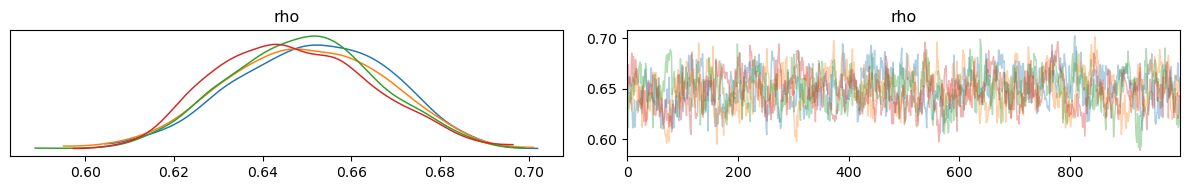

In [83]:
az.plot_trace(spt_lm_no_delta_eff_data, var_names=[
    "rho"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
output_no_delta_data_summary = spt_lm_no_delta_fit.summary()

In [ ]:
# FIRST METHOD

# Set the 'Unnamed: 0' column as the index
#output_no_delta_data_summary.set_index('Unnamed: 0', inplace=True)

# Select the covariates you're interested in
#selected_covariates = output_no_delta_data_summary.loc[['xi[1]', 'beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]', 'beta[6]', 'beta[7]', 'beta[8]', 'beta[9]', 'beta[10]', 'beta[11]']]
selected_covariates = output_no_delta_data_summary.loc[['xi[1]', 'beta[1]', 'beta[2]', 'beta[3]']]

# Calculate confidence intervals for the selected covariates
confidence_intervals = {}
for covariate in selected_covariates.index:
    lower_bound = selected_covariates.loc[covariate, '5%']
    upper_bound = selected_covariates.loc[covariate, '95%']
    confidence_intervals[covariate] = (lower_bound, upper_bound)

# Print confidence intervals
for covariate, interval in confidence_intervals.items():
    print(f"{covariate}: {interval}")

In [ ]:
# SECOND METHOD
chains_finish = az.from_cmdstanpy(spt_lm_no_delta_fit)
# Assuming you have a single chain named chain_finish
chain = chains_finish
names = ["Single Chain"]  # Rename if desired

# Assuming you have a variable named cov_names that contains the names of the covariates
# Replace this with your actual list of covariate names
#cov_names = ["beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8", "beta9", "beta10", "beta11",]
cov_names = ['beta[1]', 'beta[2]', 'beta[3]']

beta_chain = np.vstack(chain.posterior.beta)
hdi_beta = az.hdi(beta_chain, hdi_prob=0.95)

keep = np.array([~(hdi_beta[i, 0] <= 0.0 <= hdi_beta[i, 1]) for i in range(hdi_beta.shape[0])])

# Print out the names of covariates that do not contain zero within their HDI
print("{0}:\n{1}\n".format(names[0], [cov_names[i] for i, k in enumerate(keep) if k]))

In [84]:
# GENERATED QUANTITIES
new_no_delta_quantities = spt_lm_no_delta_eff.generate_quantities(data=spt_lm_no_delta_data, previous_fit=spt_lm_no_delta_fit)

new_no_delta_quantities.draws().shape

print(new_no_delta_quantities.draws().shape, new_no_delta_quantities.column_names)
for i in range(3):
    print (new_no_delta_quantities.draws()[i,:])

sample_plus = new_no_delta_quantities.draws_pd(inc_sample=True)
print(type(sample_plus),sample_plus.shape)
names = list(sample_plus.columns.values[7:18])
sample_plus.iloc[0:3, :]

17:58:41 - cmdstanpy - INFO - Chain [1] start processing
17:58:41 - cmdstanpy - INFO - Chain [2] start processing
17:58:41 - cmdstanpy - INFO - Chain [3] start processing
17:58:41 - cmdstanpy - INFO - Chain [4] start processing
18:00:09 - cmdstanpy - INFO - Chain [4] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [3] done processing
18:00:09 - cmdstanpy - INFO - Chain [2] done processing
18:00:17 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".
18:00:17 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".
18:00:17 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".
18:00:17 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".
18:00:17 - cmdstanpy - WARNING - Sample doesn't 

(1000, 4, 6132) ('zero[1]', 'zero[2]', 'zero[3]', 'zero[4]', 'zero[5]', 'zero[6]', 'zero[7]', 'zero[8]', 'zero[9]', 'zero[10]', 'zero[11]', 'zero[12]', 'zero[13]', 'zero[14]', 'zero[15]', 'zero[16]', 'zero[17]', 'zero[18]', 'zero[19]', 'zero[20]', 'zero[21]', 'zero[22]', 'zero[23]', 'zero[24]', 'zero[25]', 'zero[26]', 'zero[27]', 'zero[28]', 'zero[29]', 'zero[30]', 'zero[31]', 'zero[32]', 'zero[33]', 'zero[34]', 'zero[35]', 'zero[36]', 'zero[37]', 'zero[38]', 'zero[39]', 'zero[40]', 'zero[41]', 'zero[42]', 'gamma_pred_sim[1,1]', 'gamma_pred_sim[1,2]', 'o_pred_sim_t[1,1,1]', 'o_pred_sim_t[1,2,1]', 'o_pred_sim_t[1,3,1]', 'o_pred_sim_t[1,4,1]', 'o_pred_sim_t[1,5,1]', 'o_pred_sim_t[1,6,1]', 'o_pred_sim_t[1,7,1]', 'o_pred_sim_t[1,8,1]', 'o_pred_sim_t[1,9,1]', 'o_pred_sim_t[1,10,1]', 'o_pred_sim_t[1,11,1]', 'o_pred_sim_t[1,12,1]', 'o_pred_sim_t[1,13,1]', 'o_pred_sim_t[1,14,1]', 'o_pred_sim_t[1,15,1]', 'o_pred_sim_t[1,16,1]', 'o_pred_sim_t[1,17,1]', 'o_pred_sim_t[1,18,1]', 'o_pred_sim_t[1,19,

18:00:17 - cmdstanpy - WARNING - Sample doesn't contain draws from warmup iterations, rerun sampler with "save_warmup=True".


<class 'pandas.core.frame.DataFrame'> (4000, 11905)


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,rho,xi[1],beta[1],...,"Sigma_eta_inv[33,42]","Sigma_eta_inv[34,42]","Sigma_eta_inv[35,42]","Sigma_eta_inv[36,42]","Sigma_eta_inv[37,42]","Sigma_eta_inv[38,42]","Sigma_eta_inv[39,42]","Sigma_eta_inv[40,42]","Sigma_eta_inv[41,42]","Sigma_eta_inv[42,42]"
0,6889.13,0.851186,0.011549,9.0,511.0,0.0,-5736.06,0.664774,1.09910,0.036522,...,4.89207,1.86675,1.082710,0.491730,-0.033721,1.13567,-11.1547,0.443994,0.953161,590.435
1,6824.37,0.856261,0.011549,9.0,511.0,0.0,-5720.56,0.645157,1.20454,0.034740,...,4.65590,1.77663,1.030440,0.467991,-0.032093,1.08084,-10.6162,0.422559,0.907146,561.930
2,6780.16,0.910470,0.011549,9.0,511.0,0.0,-5658.53,0.645499,1.20443,0.010248,...,4.50458,1.71889,0.996952,0.452781,-0.031050,1.04572,-10.2712,0.408826,0.877663,543.667


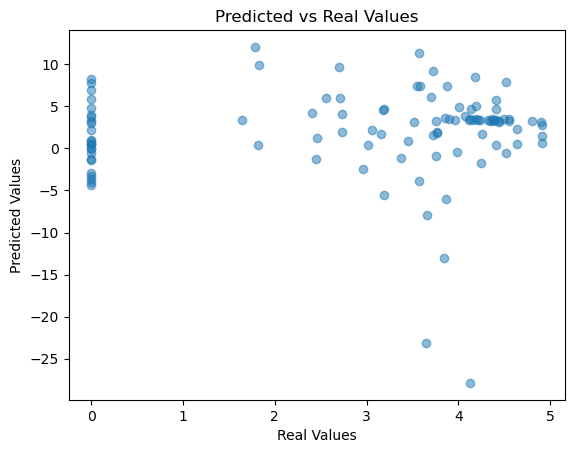

In [102]:
# PLOT

# Assuming your validation set is named 'validation_set'
# and it contains the real values for the ozone levels
# For example, if your validation set has a column named 'ozone_level':
real_values = processed_data_validation['Valore_log']

# Extract the column names that start with 'y_pred_sim'
y_pred_columns = [col for col in sample_plus.columns if col.startswith('y_pred_sim')]

# Select only the columns corresponding to 'y_pred_sim[i,j,k]'
predicted_values = sample_plus[y_pred_columns].values.mean(axis = 0)

# Plot the predicted values against the real values
plt.scatter(valore_array_validation, predicted_values, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Real Values')
plt.show()

# XI. Saving Things

In [ ]:
import pickle
import pandas as pd
from datetime import datetime

# Generate a unique timestamp
unique_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the Stan model code
stan_model_code = spt_lm
stan_file_name = f"stan_model_{unique_timestamp}.stan"
with open(stan_file_name, "w") as file:
    file.write(stan_model_code)

# Save the Stan fit object
stan_fit = spt_lm_fit
fit_file_name = f"stan_fit_{unique_timestamp}.pkl"
with open(fit_file_name, "wb") as file:
    pickle.dump(stan_fit, file)

# Save the trace plot
#trace_plot = az.plot_trace(spt_lm_eff_data, var_names=["Sigma_eta"], compact=False)  # replace with your actual plot object
#plot_file_name = f"trace_plot_{unique_timestamp}.png"
#trace_plot.figure.savefig(plot_file_name)
#plt.close(trace_plot.figure)

# Save the summary of the fit object
summary_df = pd.DataFrame(spt_lm_fit.summary())
summary_file_name = f"stan_summary_{unique_timestamp}.csv"
summary_df.to_csv(summary_file_name)